# The Divide Between Falsity and Honesty: A Classifier for Fake News

## Developed by Rolando Franqui and Connor Brown

### Importing Libraries and Sources

In [71]:
import os
import re
import numpy as np
import pandas as pd
import nltk
import sklearn
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from collections import Counter

from scipy.cluster.hierarchy import dendrogram
from scipy.stats import entropy

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer

# Modules from scikit-learn
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

# Packages for plotting
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.3) # Set the style for the plots

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cdbrown0702/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/cdbrown0702/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/cdbrown0702/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Reading in collections | Defining structures

In [34]:
fake = pd.read_csv("Dataset/Fake.csv")
true = pd.read_csv("Dataset/True.csv")

In [35]:
# intentions | effect of the article
intents = ['true', 'fake']

# Initialize necessary counters for total words, document freqency, and counts by intention
all_counts = Counter()
doc_counts = Counter()
intent_counts = {intent: Counter() for intent in intents}

# Initializes necessary data strux
art_data = []
art_intents = []

# used for article iteration
count = 0

stop_words = set(stopwords.words('english'))
tokenizer = nltk.RegexpTokenizer(r"\w+")

# iterate through true articles
for index,row in true.iterrows():
    art_counter = Counter()
    
    # define article-level structures
    art_data.append({
        "title": row['title'],
        "text": row['text'],
        "subject": row['subject'],
        "date": row['date'],
        "counts": art_counter,
        "intent": intents[0]
    })
    art_intents.append(intents[0])
    
    # tokenizes each article, removing stop words and punctuation
    filtTokens = []
    
    tokens = [word_tokenize(x) for x in true.iloc[count]['text'].split()]
    for wordList in tokens:
        for word in wordList:
            if word not in stop_words:
                filtTokens.append(word)
    tempTokens = ' '.join([str(elem) for elem in filtTokens])
    filtTokens = tokenizer.tokenize(tempTokens)

    # synthesizes article-level observations into counters
    art_counter.update(filtTokens)
    intent_counts['true'].update(art_counter)
    doc_counts.update(art_counter.keys())
    all_counts += art_counter
    
    count += 1
    
# resets for fake articles
count = 0

# iterate through fake articles
for index,row in fake.iterrows():
    art_counter = Counter()
    
    # define article-level structures
    art_data.append({
        "title": row['title'],
        "text": row['text'],
        "subject": row['subject'],
        "date": row['date'],
        "counts": art_counter,
        "intent": intents[1]
    })
    art_intents.append(intents[1])
    
    # tokenizes each article, removing stop words and punctuation
    filtTokens = []
    
    tokens = [word_tokenize(x) for x in fake.iloc[count]['text'].split()]
    for wordList in tokens:
        for word in wordList:
            if word not in stop_words:
                filtTokens.append(word)
    tempTokens = ' '.join([str(elem) for elem in filtTokens])
    filtTokens = tokenizer.tokenize(tempTokens)

    # synthesizes article-level observations into counters
    art_counter.update(filtTokens)
    intent_counts['fake'].update(art_counter)
    doc_counts.update(art_counter.keys())
    all_counts += art_counter
    
    count += 1

# Feature Analysis

In [36]:
# creates vocabulary with words appearing in more than 2 documents
vocabulary = []
for wtype, doc in doc_counts.most_common():
    if doc > 2:
        vocabulary.append(wtype)

In [37]:
# builds Numpy vectors to be used in feature analysis
def build_vectors(vocabulary):
    vectors = []
    for s in art_data:
        counts = s['counts']
        v = np.array([counts[x] for x in vocabulary])
        vectors.append(v)
    return vectors

article_vectors = build_vectors(vocabulary)

### Visualizing Data using TruncatedSVD

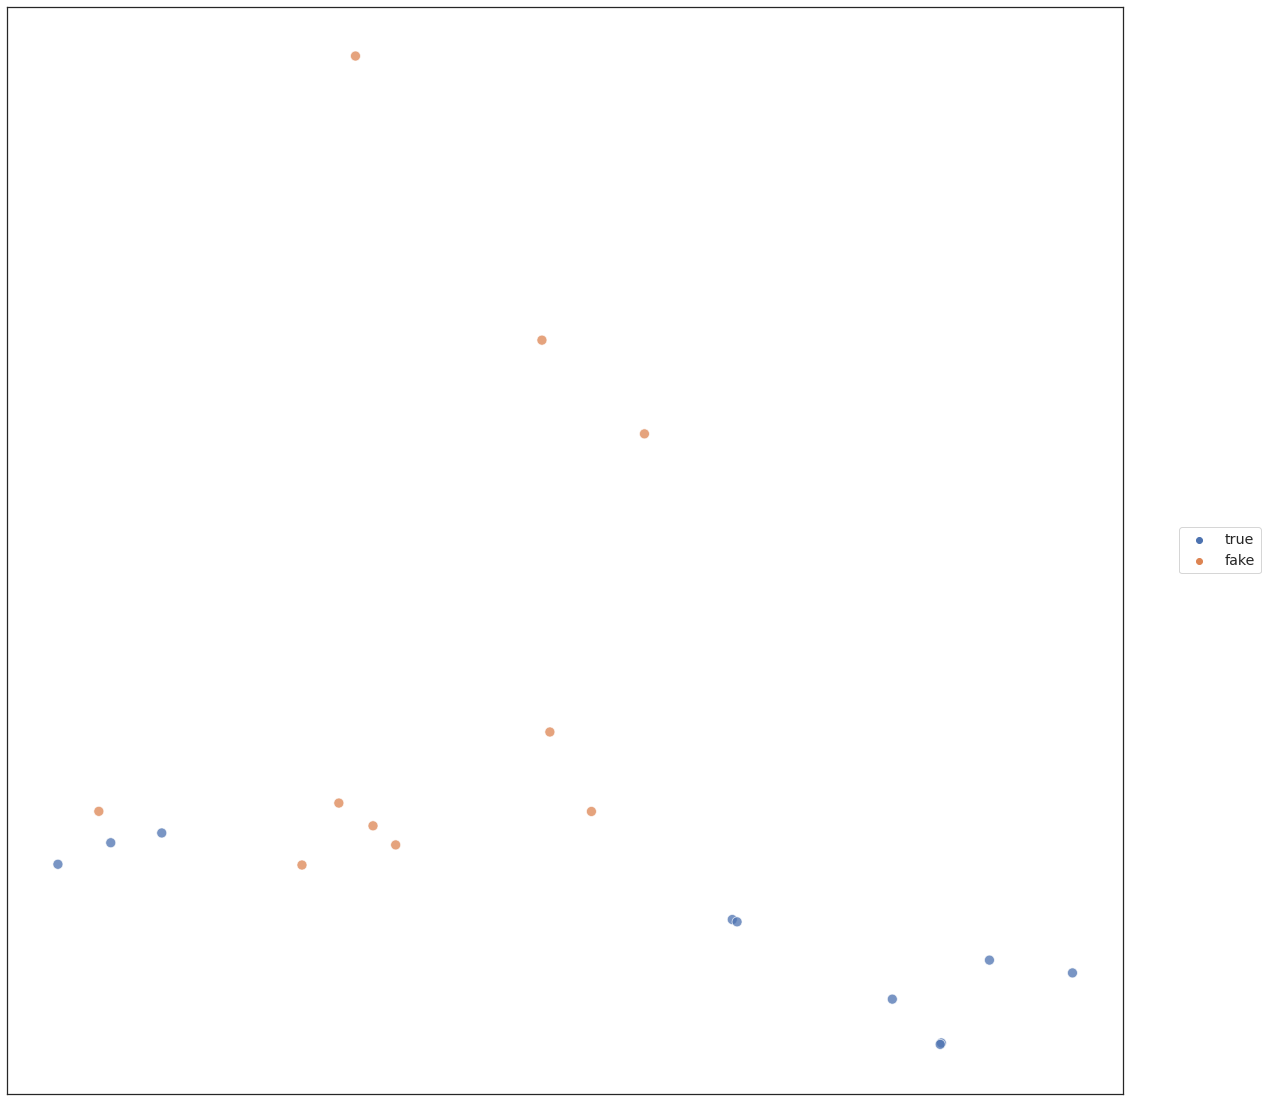

In [15]:
# Creates a TruncatedSVD plot to show patterns in data association
def plot_articles(vectors):
    svd_model = TruncatedSVD(n_components = 2)
    vectors_2d = svd_model.fit_transform(vectors)
    
    plt.figure(figsize=(20,20))
    _ = sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], hue=art_intents,
                        s=100, alpha=.75)
    _ = plt.legend(loc="center left", bbox_to_anchor=(1.05, .5),borderaxespad=0)
    _ = plt.xticks([])
    _ = plt.yticks([])

plot_articles(article_vectors) ## we can see clear clusters; while true is more scattered, fake is more confined to specific features

### Naive Bayes Classifier

In [38]:
# Trains a Naive Bayes classifier to justify the usage of our features
def classify_articles(vectors, smoothing=1):
    model = MultinomialNB(alpha=smoothing, fit_prior=False)
    cross_validator = LeaveOneOut()
    
    scores = cross_val_score(model, vectors, art_intents, cv=cross_validator)
    
    print("Ov. Accuracy: {:.1f}%\n".format(100 * sum(scores) / len(scores)))
    
    int_scores = {i:[] for i in intents}
    for x, intent in enumerate(art_intents):
        int_scores[intent].append(scores[x])
    for i in intents:
        int_name = i.title() + '' if i == 'true' else i.title()
        print("{} Accuracy: {:.1f}%".format(int_name, 100 * sum(int_scores[i]) / len(int_scores[i])))

classify_articles(article_vectors) ## very accurate

Ov. Accuracy: 98.5%

True Accuracy: 99.2%
Fake Accuracy: 97.8%


### Determining useful features

In [44]:
# Determines lengths to be used in creating table and g-scores
lencollect = sum([all_counts[word] for word in vocabulary])
lenintent = {intent: sum([intent_counts[intent][word] for word in vocabulary]) for intent in intents}

# Creates a contingency table using a specific word and intent
def contingency(word, intent):
    table = np.zeros((2, 2))
    templen = lenintent[intent]
    counter = intent_counts[intent]
    
    table[0,0] = counter[word]
    table[1,0] = all_counts[word] - counter[word]
    table[0,1] = templen - counter[word]
    table[1,1] = (lencollect - templen) - (all_counts[word] - counter[word])
    return table

# Defines g-scores into a contingency table
def gscore(table, signed=False):
    rows = table.sum(axis=1)
    columns = table.sum(axis=0)
    
    score = 2 * table.sum() * (entropy(rows) + entropy(columns) - entropy(table.flatten()))
    
    if signed:
        asser(table.shape == (2,2))
        if table[0,0] / table[:, 0].sum() < table[0,1]/table[:, 1].sum() > 0:
            score *= 1
    return score

In [67]:
table = contingency('tax', 'true')
gscore(table)

948.2427154432182

By looking at specific buzzwords as well as their frequency by intent, we can see that Trump has 70% more uses in
fake news articles, and also has an incredibly high Dunning g-score; the vocabulary with common words is very useful
as a feature of our dataset.

# Clustering

In [40]:
cluster_vectors = []
for struct in art_data:
    counts = struct['counts']
    vector = np.array([counts[word] for word in vocabulary])
    
    vector = vector / vector.sum()
    cluster_vectors.append(vector)
    
clust_tents = [i['intent'] for i in art_data]

In [41]:
def p_clust(clust_labels):
    n_clusters = max(clust_labels) + 1
    
    # Group indices
    clust_ind = [[] for n in range(n_clusters)]
    
    for n, l in enumerate(clust_labels):
        clust_ind[l].append(n)
        
    # Print clusters
    for ind in range(n_clusters):
        print("Cluster {}".format(ind))
        
        for article in clust_ind[ind]:
            struct = art_data[article]
            print("  {} - {}".format(struct['intent'], struct['title']))

def plot(vectors, clust_labels, centroids=None):
    model = TruncatedSVD(n_components = 2)
    vectors_2d = model.fit_transform(vectors)
    
    plt.figure(figsize = (6,6))
    _ = sns.scatterplot(x = vectors_2d[:, 0], y = vectors_2d[:, 1], style = clust_tents,
                        hue = clust_labels, palette = 'tab10', s = 100, alpha = .75)
    _ = plt.legend(loc = "center left", bbox_to_anchor = (1.05, .5), borderaxespad = 0)
    _ = plt.xticks([])
    _ = plt.yticks([])
    
    if centroids is not None:
        hues = sns.color_palette('tab10')
        centroids_2d = model.transform(centroids)
        for i in range(centroids_2d.shape[0]):
            hue = hues[i % 10]
            plt.scatter(x=[centroids_2d[i, 0]], y=[[centroids_2d[i, 1]]],
                        marker='*', color=hue, s=300)

### Agglomerative Clustering

In [21]:
def dendro(model,  **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

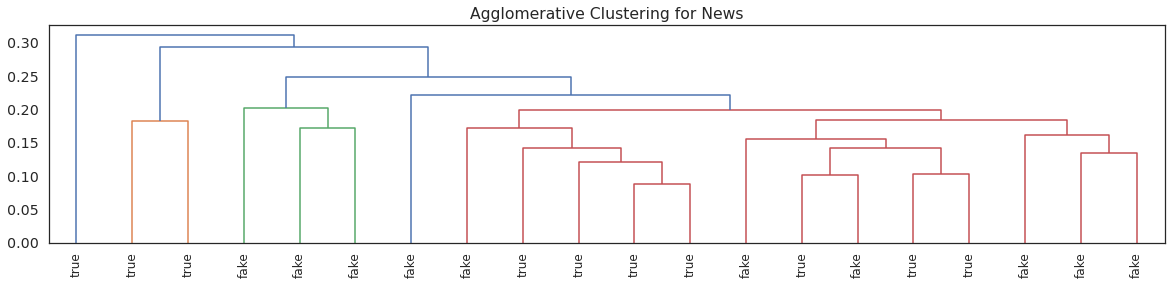

In [22]:
plt.figure(figsize = (20, 4))

agglom = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='euclidean', linkage='complete')
agglom.fit(cluster_vectors)

dendro(agglom, leaf_rotation=90, leaf_font_size=12, labels = clust_tents)
_ = plt.title('Agglomerative Clustering for News')

In [23]:
agglom2 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
labels2 = agglom2.fit_predict(cluster_vectors)

p_clust(labels2)

Cluster 0
  fake -  Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
  fake -  Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’
  fake -  Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)
Cluster 1
  true - As U.S. budget fight looms, Republicans flip their fiscal script
  true - U.S. military to accept transgender recruits on Monday: Pentagon
  true - Senior U.S. Republican senator: 'Let Mr. Mueller do his job'
  true - FBI Russia probe helped by Australian diplomat tip-off: NYT
  true - Trump wants Postal Service to charge 'much more' for Amazon shipments
  true - White House, Congress prepare for talks on spending, immigration
  true - Trump says Russia probe will be fair, but timeline unclear: NYT
  fake -  Drunk Bragging Trump Staffer Started Russian Collusion Investigation
  fake -  Pope Francis Just Called Out Donald Trump During His Christmas Speech
  fake -  Fresh Off The Golf Co

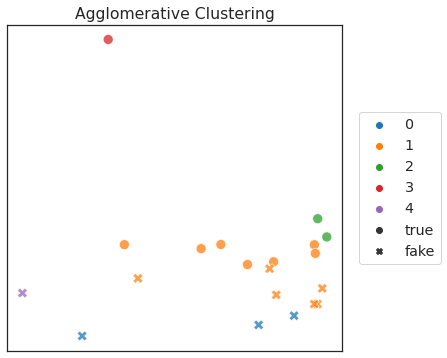

In [24]:
plot(cluster_vectors, labels2)
_ = plt.title("Agglomerative Clustering")

### K-Means

In [42]:
kmeans = KMeans(n_clusters=2)
labels3 = kmeans.fit_predict(cluster_vectors)
centroids = kmeans.cluster_centers_

p_clust(labels3)

Cluster 0
  true - U.S. military to accept transgender recruits on Monday: Pentagon
  true - Senior U.S. Republican senator: 'Let Mr. Mueller do his job'
  true - FBI Russia probe helped by Australian diplomat tip-off: NYT
  true - Trump wants Postal Service to charge 'much more' for Amazon shipments
  true - Trump says Russia probe will be fair, but timeline unclear: NYT
  true - Factbox: Trump on Twitter (Dec 29) - Approval rating, Amazon
  true - Trump on Twitter (Dec 28) - Global Warming
  true - Factbox: Trump on Twitter (Dec 28) - Vanity Fair, Hillary Clinton
  true - Trump on Twitter (Dec 27) - Trump, Iraq, Syria
  true - Virginia officials postpone lottery drawing to decide tied statehouse election
  true - U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources
  true - Trump on Twitter (Dec 26) - Hillary Clinton, Tax Cut Bill
  true - U.S. appeals court rejects challenge to Trump voter fraud panel
  true - Treasury Secretary Mnuchin was sent gift-wrapped box 

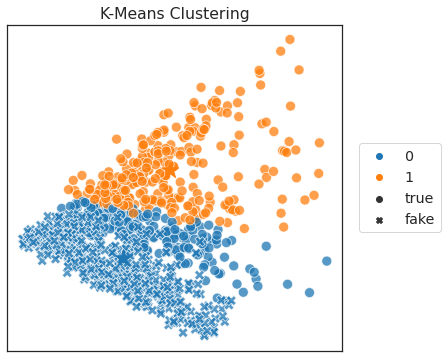

In [43]:
plot(cluster_vectors, labels3, centroids = centroids)
_ = plt.title("K-Means Clustering")

# Classifier

In [78]:
# Encoding the data
fake['Label'] = 1
true['Label'] = 0

# Joining both true and false into one DF
data = pd.concat([true,fake],axis=0,ignore_index=True)

In [79]:
# Moving all important features into a single column 

data['text'] = data['title'] + data['text']
data = data.drop(['title'],axis=1)

### Cleaning, Tokenizing and Lemmatizing
stop = stopwords.words('english')
def clean_up(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
data['text'] = data['text'].apply(lambda x:clean_up(x))
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

def lemmatize_words(text):
    wnl = nltk.stem.WordNetLemmatizer()
    lematized = ' '.join([wnl.lemmatize(word) for word in text.split()])    
    return lematized
data['text'] = data['text'].apply(lemmatize_words)

In [80]:
## Creating Training and Testing Sets
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(data['text'], y,test_size=0.40,random_state=53)

In [81]:
## Creating a Bag of Words and Converting Feature into Numbers to feed into the model.
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)
print(count_train.shape)

(600, 15793)


In [82]:
# Time for some fun stuff, training Naive Bayes
from sklearn.metrics import classification_report
nb_classifier1 = MultinomialNB()
nb_classifier1.fit(count_train, y_train)
pred1 = nb_classifier1.predict(count_test)
print(classification_report(y_test, pred1, target_names = ['Fake','True']))

              precision    recall  f1-score   support

        Fake       0.93      0.98      0.95       202
        True       0.98      0.92      0.95       198

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400

